In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_dyn
import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer

from ELPH_NVAR import SVDNVAR

In [2]:
runs = ELPH_utils.load_runs()

runs_w002 = ELPH_utils.load_runs(filename='../runs_w0.02.npz')
runs_w003 = ELPH_utils.load_runs(filename='../runs_w0.03.npz')
runs_w01 = ELPH_utils.load_runs(filename='../runs_w0.1.npz')

runs = runs[:] + runs_w002[:] + runs_w003 + runs_w01


n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

# for k in range(len(runs)):
#     runs[k] = runs[k][:,:200:2]

400 loaded with n_kmax = 80


runs[0] shape:  (80, 400)


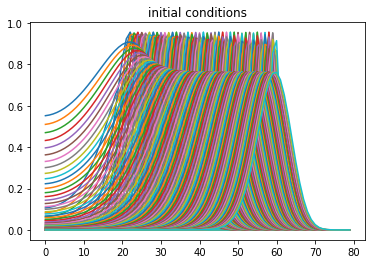

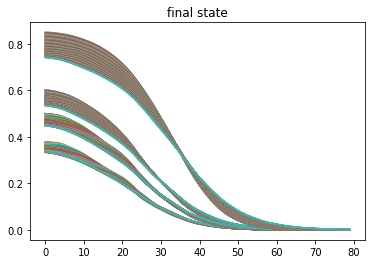

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  10
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (20, 159201)
NVAR state shape:  (231, 159201)
target shape:  (10, 159201)
weights shape:  (231, 10)
NVAR error:  0.038134997840941764
NVAR error compared to SVD approximated run:  0.012911168059256073


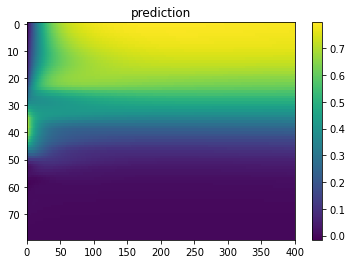

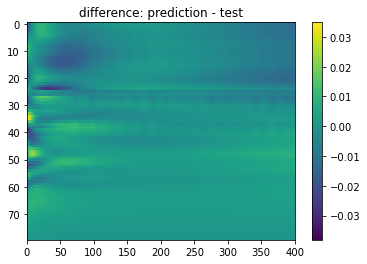

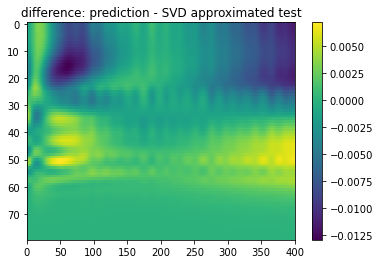

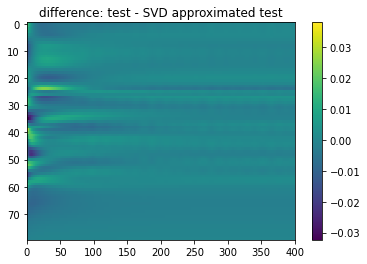

In [11]:
NVAR = SVDNVAR(runs)

scaler = ELPH_Scaler.normalize_scaler(0.3)
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
# optimizer = ELPH_Optimizer.lstsqrs()


train_runs = runs[::1]
test_run = train_runs.pop(332)

NVAR.load_runs(train_runs)
NVAR.train(rdim=10, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler, full_hist=False)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

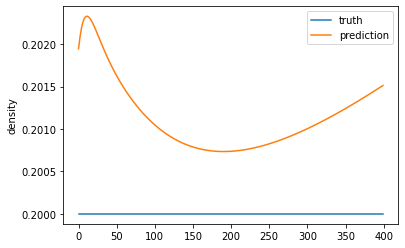

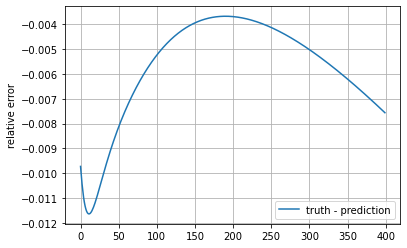

In [15]:
N_test_noPI = ELPH_dyn.get_density(test_run, 4./80.)
N_pred_noPI = ELPH_dyn.get_density(pred, 4./80.)

plt.plot(N_test_noPI, label='truth')
plt.plot(N_pred_noPI, label='prediction')
plt.legend()
plt.ylabel('density')
plt.show()

plt.grid()
plt.plot((N_test_noPI-N_pred_noPI)/N_test_noPI, label='truth - prediction')
plt.legend()
plt.ylabel('relative error')
plt.show()

ridge regression loss: 0.3961872
epoch: 1 loss: 0.40497038
epoch: 2 loss: 0.39643005
epoch: 3 loss: 0.39583117
epoch: 4 loss: 0.3954621
epoch: 5 loss: 0.39545727
epoch: 6 loss: 0.39594996
epoch: 7 loss: 0.39584446
epoch: 8 loss: 0.3947724
epoch: 9 loss: 0.39391834
epoch: 10 loss: 0.3945298
epoch: 11 loss: 0.39378884
epoch: 12 loss: 0.39465237
epoch: 13 loss: 0.3938944
epoch: 14 loss: 0.393066
epoch: 15 loss: 0.39474538
epoch: 16 loss: 0.3932716
epoch: 17 loss: 0.39353755
epoch: 18 loss: 0.3940395
epoch: 19 loss: 0.3930722
epoch: 20 loss: 0.39226067
epoch: 21 loss: 0.3911013
epoch: 22 loss: 0.39094216
epoch: 23 loss: 0.39192972
epoch: 24 loss: 0.38964158
epoch: 25 loss: 0.39060262
epoch: 26 loss: 0.39014077
epoch: 27 loss: 0.3891165
epoch: 28 loss: 0.39037448
epoch: 29 loss: 0.39038926
epoch: 30 loss: 0.39013338
epoch: 31 loss: 0.38950968
epoch: 32 loss: 0.38799042
epoch: 33 loss: 0.3875142
epoch: 34 loss: 0.3886659
epoch: 35 loss: 0.38705122
epoch: 36 loss: 0.38851374
epoch: 37 loss: 0

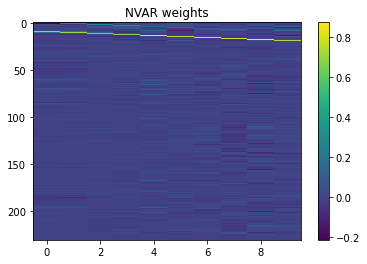

In [6]:
scaler = ELPH_Scaler.normalize_scaler(0.3)
# optimizer = ELPH_Optimizer.ridge(alpha=10.**-2.8)
optimizer = ELPH_Optimizer.PIML_adam(alpha=10.**-2.8, lambda1=100, epochs = 100, mini_batch_size = 5000)

train_runs = runs[::1]
test_run = train_runs.pop(82)

NVAR.load_runs(train_runs)
NVAR.train(rdim=10, n_VAR_steps=2, NVAR_p=2, intercept=True, optimizer=optimizer, scaler=scaler, full_hist=False)

NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

NVAR error:  0.038134997840941764


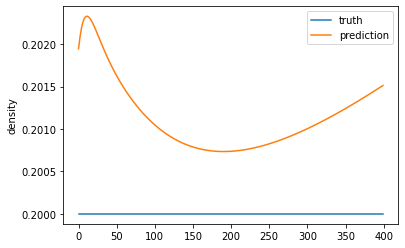

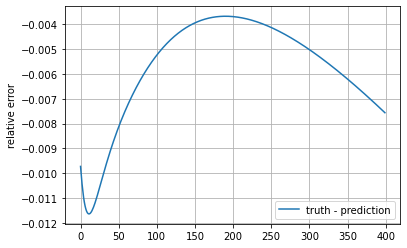

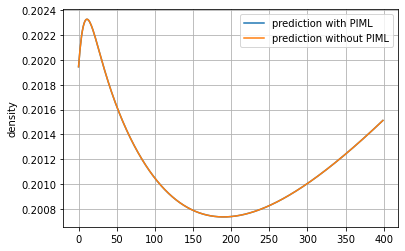

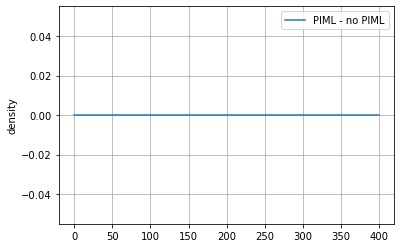

In [16]:
print('NVAR error: ', NVAR.get_error(test_run, norm='max') )


pred_PIML = NVAR.predict_single_run(test_run)


N_test = ELPH_dyn.get_density(test_run, 4./80.)
N_pred = ELPH_dyn.get_density(pred_PIML, 4./80.)

plt.plot(N_test, label='truth')
plt.plot(N_pred, label='prediction')
plt.legend()
plt.ylabel('density')
plt.show()

plt.grid()
plt.plot((N_test-N_pred)/N_test, label='truth - prediction')
plt.legend()
plt.ylabel('relative error')
plt.show()


plt.grid()
plt.plot(N_pred, label='prediction with PIML')
plt.plot(N_pred_noPI, label='prediction without PIML')
plt.legend()
plt.ylabel('density')
plt.show()

plt.grid()
plt.plot(N_pred_noPI-N_pred, label='PIML - no PIML')
plt.legend()
plt.ylabel('density')
plt.show()